In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
)


# Create imbalanced classification data

In [3]:
X, y = make_classification(
    n_samples=3000,
    n_features=10,
    n_informative=4,
    n_redundant=2,
    weights=[0.9, 0.1],   # 90% class 0, 10% class 1 (imbalanced)
    class_sep=1.0,
    random_state=10
)

print("X shape:", X.shape)
print("Positive rate:", y.mean())


X shape: (3000, 10)
Positive rate: 0.104


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, stratify=y
)
print("Train positive rate:", y_train.mean())
print("Test positive rate:", y_test.mean()) 


Train positive rate: 0.10416666666666667
Test positive rate: 0.10333333333333333


# Baseline classifier

In [7]:
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)

print("Baseline accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Baseline precision:", precision_score(y_test, y_pred_baseline))
print("Baseline recall:", recall_score(y_test, y_pred_baseline))
print("Baseline F1:", f1_score(y_test, y_pred_baseline))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_baseline))
cm = confusion_matrix(y_test, y_pred_baseline)
tn, fp, fn, tp = cm.ravel()
print("TN, FP, FN, TP =", tn, fp, fn, tp)


Baseline accuracy: 0.8966666666666666
Baseline precision: 0.0
Baseline recall: 0.0
Baseline F1: 0.0
Confusion matrix:
 [[538   0]
 [ 62   0]]
TN, FP, FN, TP = 538 0 62 0


c:\Users\User2\proxy_prep\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy: “How often am I correct overall?”
Good when classes are balanced and costs are similar.

Precision: “When I predict positive, how often am I correct?”
Use when false positives are costly.

Recall: “Of all actual positives, how many did I catch?”
Use when false negatives are costly.

F1: “Single score balancing precision + recall.”
Use when you care about both and classes are imbalanced.

# Real model: logistic regression (with scaling)

In [9]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000)) 
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print("TN, FP, FN, TP =", tn, fp, fn, tp)

print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.945
Precision: 0.8918918918918919
Recall: 0.532258064516129
F1: 0.6666666666666666
Confusion matrix:
 [[534   4]
 [ 29  33]]
TN, FP, FN, TP = 534 4 29 33

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       538
           1       0.89      0.53      0.67        62

    accuracy                           0.94       600
   macro avg       0.92      0.76      0.82       600
weighted avg       0.94      0.94      0.94       600



# Probabilities + ROC-AUC + PR-AUC

ROC-AUC: 0.8983391293920134
PR-AUC (Average Precision): 0.7228234887179853


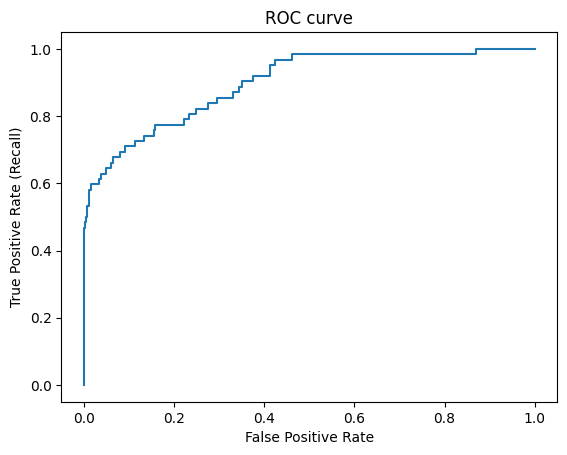

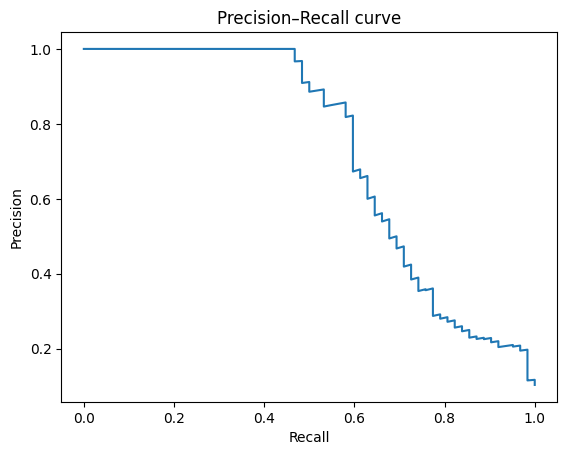

In [17]:
y_proba = model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba))

fpr, tpr, roc_thresh = roc_curve(y_test, y_proba)
prec, rec, pr_thresh = precision_recall_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve")
plt.show()

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.show()


In [ ]:
thresholds = np.linspace(0.01, 0.99, 99)
f1s = []
precisions = []
recalls = []

for thr in thresholds:
    y_hat = (y_proba >= thr).astype(int)
    precisions.append(precision_score(y_test, y_hat, zero_division=0))
    recalls.append(recall_score(y_test, y_hat))
    f1s.append(f1_score(y_test, y_hat, zero_division=0))

best_i = int(np.argmax(f1s))
best_thr = float(thresholds[best_i])

print("Best threshold (by F1):", best_thr)
print("Precision/Recall/F1 at best thr:", precisions[best_i], recalls[best_i], f1s[best_i])


Best threshold (by F1): 0.41000000000000003
Precision/Recall/F1 at best thr: 0.8222222222222222 0.5967741935483871 0.6915887850467289


compare confusion matrices: default vs best threshold

In [ ]:
y_default = (y_proba >= 0.5).astype(int)
y_best = (y_proba >= best_thr).astype(int)

print("Default thr=0.5 CM:\n", confusion_matrix(y_test, y_default))
print("Best thr CM:\n", confusion_matrix(y_test, y_best))


Default thr=0.5 CM:
 [[534   4]
 [ 29  33]]
Best thr CM:
 [[530   8]
 [ 25  37]]


// ...existing code...

# Full explanation: `predict_proba(X)[:, 1]`, thresholds, and curves

When logistic regression outputs `predict_proba(X)[:, 1]`, it computes the probability that the label is class 1 (the "positive" class) given the features $x$.

Mathematically:
$$
p = P(y = 1 \mid x).
$$

Plain language: it's the model's estimate of "how likely is this sample to belong to the positive class?"

Examples depending on what you define as class 1:
- If 1 = "bad batch / defect" then $P(y=1\mid x)$ = "probability this is defective".
- If 1 = "consumer dislikes" then $P(y=1\mid x)$ = "probability this formulation will be disliked".
- If 1 = "fails acceptance test" then $P(y=1\mid x)$ = "probability it fails".

So the probability is always about the event "y equals 1".

Where does this probability come from?

Logistic regression computes a score
$$
z = w^\top x + b,
$$
then maps it to $[0,1]$ with the sigmoid:
$$
\sigma(z) = \frac{1}{1 + e^{-z}},
$$
and sets
$$
P(y = 1 \mid x) = \sigma(w^\top x + b).
$$

So:
- if $z$ is very positive → probability near $1$,
- if $z$ is very negative → probability near $0$,
- if $z = 0$ → probability $= 0.5$.

Important practical nuance

This is a model-estimated probability (the model's confidence based on learned patterns). Models can be overconfident or underconfident; that is called calibration.

Micro-example

If the model outputs $p = 0.80$ for a sample, it means: "Given the features $x$, the model thinks class 1 is 80% likely."

Then `predict` uses a threshold:

- if threshold is $0.5$ → predicts $1$ (for $p=0.80$)  
- if threshold is $0.9$ → predicts $0$ (for $p=0.80$)

Difference between `predict` and `predict_proba`

- `model.predict(X)` returns hard labels (0 or 1). Internally, for logistic regression:
  - compute $\hat{p}_i = P(y=1\mid x_i)$,
  - apply a threshold (default $0.5$),
  - decision rule:
  $$
  \hat{y}_i = \begin{cases}
  1 & \text{if } \hat{p}_i \ge 0.5,\\[4pt]
  0 & \text{if } \hat{p}_i < 0.5.
  \end{cases}
  $$
- `model.predict_proba(X)[:, 1]` returns the probabilities for class 1 (e.g. `[0.02, 0.15, 0.93, 0.48, ...]`) and does not perform thresholding.

Which one to use for threshold tuning?

Use `predict_proba`, because threshold tuning requires probabilities so you can try different thresholds:
```python
y_proba = model.predict_proba(X_test)[:, 1]
y_hat = (y_proba >= thr).astype(int)
```
So:
- `predict_proba` → choose `thr` → convert probabilities → labels.

What is "threshold"? (mental model)

Given probabilities:
sample | $p(y=1)$
---|---
A | 0.95
B | 0.70
C | 0.55
D | 0.30
E | 0.05

- If threshold = 0.5 → A, B, C predicted positive  
- If threshold = 0.8 → only A predicted positive  
- If threshold = 0.2 → A, B, C, D predicted positive

Thus:
- higher threshold → fewer positive predictions → usually higher precision, lower recall  
- lower threshold → more positive predictions → usually higher recall, lower precision

How ROC and PR curves relate to threshold

Each point on the ROC or PR curve corresponds to a specific threshold. Sliding the threshold from $1.0$ down to $0.0$:

- Threshold very high ($\approx 1.0$): predicts almost no positives → recall $\approx 0$, FPR $\approx 0$ → near $\,(0,0)$ on ROC.
- Threshold very low ($\approx 0.0$): predicts almost everything positive → recall $\approx 1$, FPR $\approx 1$ → near top-right on ROC.

So moving along ROC/PR is essentially "what happens as we lower the threshold".

// ...existing code...